<a href="https://colab.research.google.com/github/meetraj19/Agents/blob/main/Reserach_team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
%pip install autogen matplotlib

In [24]:
%pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5


In [1]:
%pip install autogen==0.1.0

In [3]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 8.5 MB/s eta 0:00:00


Set API ENDPOINT

In [4]:
from autogen.agentchat import UserProxyAgent, AssistantAgent, GroupChat, GroupChatManager
import os
from dotenv import load_dotenv
load_dotenv()

from google.colab import userdata
openai_api_key = userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = openai_api_key
config_list_gpt4 = [{"model": "gpt-4o", "api_key": os.getenv('OPENAI_API_KEY')}]

In [5]:
gpt4_config = {
    "cache_seed": 42,  # change the cache_seed for different trials
    "temperature": 0,
    "config_list": config_list_gpt4,
    "timeout": 120,
}

In [6]:
# User Proxy Agent
user_proxy = UserProxyAgent(
    name="Admin",
    human_input_mode="ALWAYS",
    system_message="1. A human admin. 2. Interact with the team. 3. Plan execution needs to be approved by this Admin.",
    code_execution_config=False,
    llm_config=gpt4_config,
    description="""Call this Agent if:
        You need guidance.
        The program is not working as expected.
        You need api key
        DO NOT CALL THIS AGENT IF:
        You need to execute the code.""",
)
# Assistant Agent - Developer
developer = AssistantAgent(
    name="Developer",
    llm_config=gpt4_config,
    system_message="""You are an AI developer. You follow an approved plan, follow these guidelines:
    1. You write python/shell code to solve tasks.
    2. Wrap the code in a code block that specifies the script type.
    3. The user can't modify your code. So do not suggest incomplete code which requires others to modify.
    4. You should print the specific code you would like the executor to run.
    5. Don't include multiple code blocks in one response.
    6. If you need to import libraries, use ```bash pip install module_name```, please send a code block that installs these libraries and then send the script with the full implementation code
    7. Check the execution result returned by the executor,  If the result indicates there is an error, fix the error and output the code again
    8. Do not show appreciation in your responses, say only what is necessary.
    9. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
    """,
    description="""Call this Agent if:
        You need to write code.
        DO NOT CALL THIS AGENT IF:
        You need to execute the code.""",
)
# Assistant Agent - Planner
planner = AssistantAgent(
    name="Planner",  #2. The research should be executed with code
    system_message="""You are an AI Planner,  follow these guidelines:
    1. Your plan should include 5 steps, you should provide a detailed plan to solve the task.
    2. Post project review isn't needed.
    3. Revise the plan based on feedback from admin and quality_assurance.
    4. The plan should include the various team members,  explain which step is performed by whom, for instance: the Developer should write code, the Executor should execute code, important do not include the admin in the tasks e.g ask the admin to research.
    5. Do not show appreciation in your responses, say only what is necessary.
    6. The final message should include an accurate answer to the user request
    """,
    llm_config=gpt4_config,
    description="""Call this Agent if:
        You need to build a plan.
        DO NOT CALL THIS AGENT IF:
        You need to execute the code.""",
)

# User Proxy Agent - Executor
executor = UserProxyAgent(
    name="Executor",
    system_message="1. You are the code executer. 2. Execute the code written by the developer and report the result.3. you should read the developer request and execute the required code",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 20,
        "work_dir": "dream",
        "use_docker": True,
    },
    description="""Call this Agent if:
        You need to execute the code written by the developer.
        You need to execute the last script.
        You have an import issue.
        DO NOT CALL THIS AGENT IF:
        You need to modify code""",
)
quality_assurance = AssistantAgent(
    name="Quality_assurance",
    system_message="""You are an AI Quality Assurance. Follow these instructions:
      1. Double check the plan,
      2. if there's a bug or error suggest a resolution
      3. If the task is not solved, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach.""",
    llm_config=gpt4_config,
)

In [11]:
allowed_transitions = {
    user_proxy: [ planner,quality_assurance],
    planner: [ user_proxy, developer, quality_assurance],
    developer: [executor,quality_assurance, user_proxy],
    executor: [developer],
    quality_assurance: [planner,developer,executor,user_proxy],
}

In [12]:
system_message_manager = "You are a manager of a research group your role is to manage the team and make sure the project is completed sucessfully."
groupchat = GroupChat(
    agents = [user_proxy, planner, developer, executor, quality_assurance], allowed_or_disallowed_speaker_transitions= allowed_transistions,
    speaker_transitions_type= "allowed", messages= [], max_round = 30 , send_introductions=True
)
mananger = GroupChatManager(groupchat=groupchat, llm_config=gpt4_config, system_message=system_message_manager)

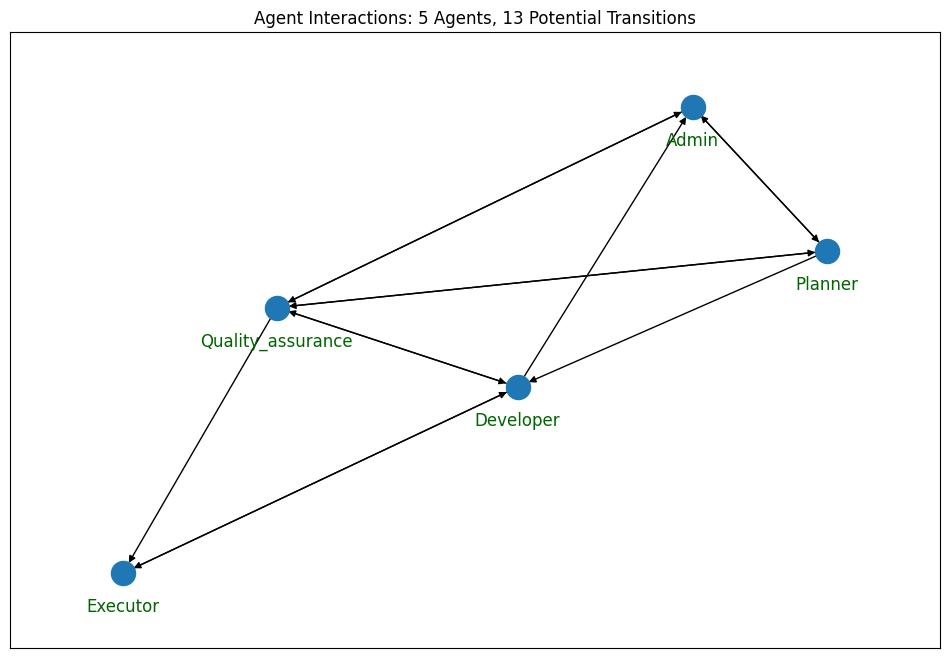

In [13]:

import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add nodes
G.add_nodes_from([agent.name for agent in groupchat.agents])

# Add edges
for key, value in allowed_transitions.items():
    for agent in value:
        G.add_edge(key.name, agent.name)

# Set the figure size
plt.figure(figsize=(12, 8))

# Visualize
pos = nx.spring_layout(G)  # For consistent positioning

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)

# Draw labels below the nodes
label_pos = {k: [v[0], v[1] - 0.1] for k, v in pos.items()}  # Shift labels below the nodes
nx.draw_networkx_labels(G, label_pos, verticalalignment='top', font_color="darkgreen")

# Adding margins
ax = plt.gca()
ax.margins(0.1)  # Increase the margin value if needed


# Adding a dynamic title
total_transitions = sum(len(v) for v in allowed_transitions.values())
title = f'Agent Interactions: {len(groupchat.agents)} Agents, {total_transitions} Potential Transitions'
plt.title(title)

plt.show()


In [ ]:
task1 = "What are 5 leading Github repos on diffusion models for the legal domain?"
chat_result = user_proxy.initiate_chat(
    mananger, message=task1,
    clear_history=True
)

Admin (to chat_manager):

What are 5 leading Github repos on diffusion models for the legal domain?

--------------------------------------------------------------------------------

Next speaker: Planner

Planner (to chat_manager):

To identify the 5 leading GitHub repositories on diffusion models for the legal domain, follow this plan:

1. **Research and Identification**  
   - **Team Member**: Developer  
   - **Task**: Conduct a search on GitHub using relevant keywords such as "diffusion models legal domain" or "legal AI diffusion models". Identify repositories that are frequently starred, forked, or have significant contributions and discussions.

2. **Evaluation of Repositories**  
   - **Team Member**: Quality Assurance  
   - **Task**: Evaluate the identified repositories based on criteria such as the number of stars, forks, recent activity, and the relevance of the content to the legal domain. Ensure that the repositories are actively maintained and have a clear focus on diffu